# new WS calibration check through bumps

Data of 15 october morning

In [2]:
%run /eos/project/l/liu/Toolbox/myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/home-e/esenes/Emittance-measurement-accuracy-precision-study/new_ws_analysis
Your IP is 172.17.0.7
2018-11-23 11:30:53


# User inputs

In [5]:
matlabVars = ['PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionOrbit.value.channelNames',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [6]:
def gimme_df(filenames, ampl):
    df = myToolbox.fromMatlabToDataFrame(filenames,matlabVars,verbose=False)
    df['Bump_mm'] = ampl
    return df

files0 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/n2mm/*.mat'))
df0 = gimme_df(files0, -2.)
files1 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/n1mm/*.mat'))
df1 = gimme_df(files1, -1.)
files2 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/0mm/*.mat'))
df2 = gimme_df(files2, 0.)
files3 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/1mm/*.mat'))
df3 = gimme_df(files3, 1.)
files4 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/2mm/*.mat'))
df4 = gimme_df(files4, 2.)
files5 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/3mm/*.mat'))
df5 = gimme_df(files5, 3.)
files6 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/4mm/*.mat'))
df6 = gimme_df(files6, 4.)

In [7]:
myDataFrame = pnd.concat([df0,df1,df2,df3,df4,df5,df6])

# Intensity

In [8]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.mean(x[500:900]))

# BPMs

In [9]:
myDataFrame['PR_BPM.AcquisitionOrbit.value.position'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x)

In [10]:
myDataFrame['Bump_amplitude'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[22, 500:900]))

# Import Jose's data from Matlab

In [14]:
# import to dict
matlabVars2 = ['Sigmas_IN','Sigmas_OUT','Centres_IN','Centres_OUT','InfoData_CycleName']
new_WS_data = scipy.io.loadmat('/eos/user/e/esenes/Emittance-measurement-accuracy-precision-study/data/new_WS_bumps/Summary_Processed.mat', squeeze_me=True, struct_as_record=False)
# fix the casting for the timestamps
liuTs = []
for k in range(263):    
    ts = new_WS_data['InfoData_CycleName'][k]
    ts_unix = time.mktime(datetime.datetime.strptime(str(ts), '%Y.%m.%d.%H.%M.%S.%f').timetuple())
#     ts_unix += 3 #acquisition offset
    liuTs.append(myToolbox.unixtime2datetime(ts_unix))
# import to dataframe
LIU_df = pnd.DataFrame([],index=liuTs)

LIU_df['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)

for k, l in enumerate(LIU_df.index):
    LIU_df['Sigmas_IN'].loc[l] = new_WS_data['Sigmas_IN'][k]
    LIU_df['Sigmas_OUT'].loc[l] = new_WS_data['Sigmas_OUT'][k]
    LIU_df['Centre_IN'].loc[l] = new_WS_data['Centres_IN'][k]
    LIU_df['Centre_OUT'].loc[l] = new_WS_data['Centres_OUT'][k]
    
# UTC time fix --> go all in local time
LIU_df.index = LIU_df.index + pnd.DateOffset(hours=2, seconds=3, milliseconds=900) 

# head/tail chop
LIU_df = LIU_df.drop(LIU_df.iloc[127:].index,axis=0)
LIU_df = LIU_df.drop(LIU_df.iloc[:11].index,axis=0)

In [15]:
# manual adjustment of the data not matching ...
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:12:55.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:14:07.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:15:19.900000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:14:40.300000'].name)

LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:50:43.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:52:31.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:57:55.900000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:57:16.300000'].name)


In [16]:
myDataFrame['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)

for k in range(len(myDataFrame)):
    if (myDataFrame.index[k] == LIU_df.index[k]):
        myDataFrame['Sigmas_IN'].iloc[k] = LIU_df['Sigmas_IN'].iloc[k]
        myDataFrame['Sigmas_OUT'].iloc[k] = LIU_df['Sigmas_OUT'].iloc[k]
        myDataFrame['Centre_IN'].iloc[k] = LIU_df['Centre_IN'].iloc[k]
        myDataFrame['Centre_OUT'].iloc[k] = LIU_df['Centre_OUT'].iloc[k]
    else:
        print(k)
        myDataFrame['Sigmas_IN'].iloc[k] = np.nan
        myDataFrame['Sigmas_OUT'].iloc[k] = np.nan
        myDataFrame['Centre_IN'].iloc[k] = np.nan
        myDataFrame['Centre_OUT'].iloc[k] =np.nan

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


15
31
62
78


In [17]:
# manual cleanup
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:47:04.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:57:52.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:26:04.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:37:28.300000'].name)



# Finally the plot 

In [18]:
# data grabber for arrays with nans
def sig(x, idx):
    try:
        return x[idx]
    except:
        return x
# linear fitting
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

In [80]:
# bad shots LIU WS
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 13:00:55.900'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:39:19.900'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:40:31.900'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:20:07.900'].name)

PM A
slope = -0.962 ± 0.002
intercept = -4.268 ± 0.006

PM B
slope = -0.962 ± 0.002
intercept = -4.267 ± 0.006

PM C
slope = -0.947 ± 0.003
intercept = -4.226 ± 0.007

PM D
slope = -0.961 ± 0.008
intercept = -4.107 ± 0.021



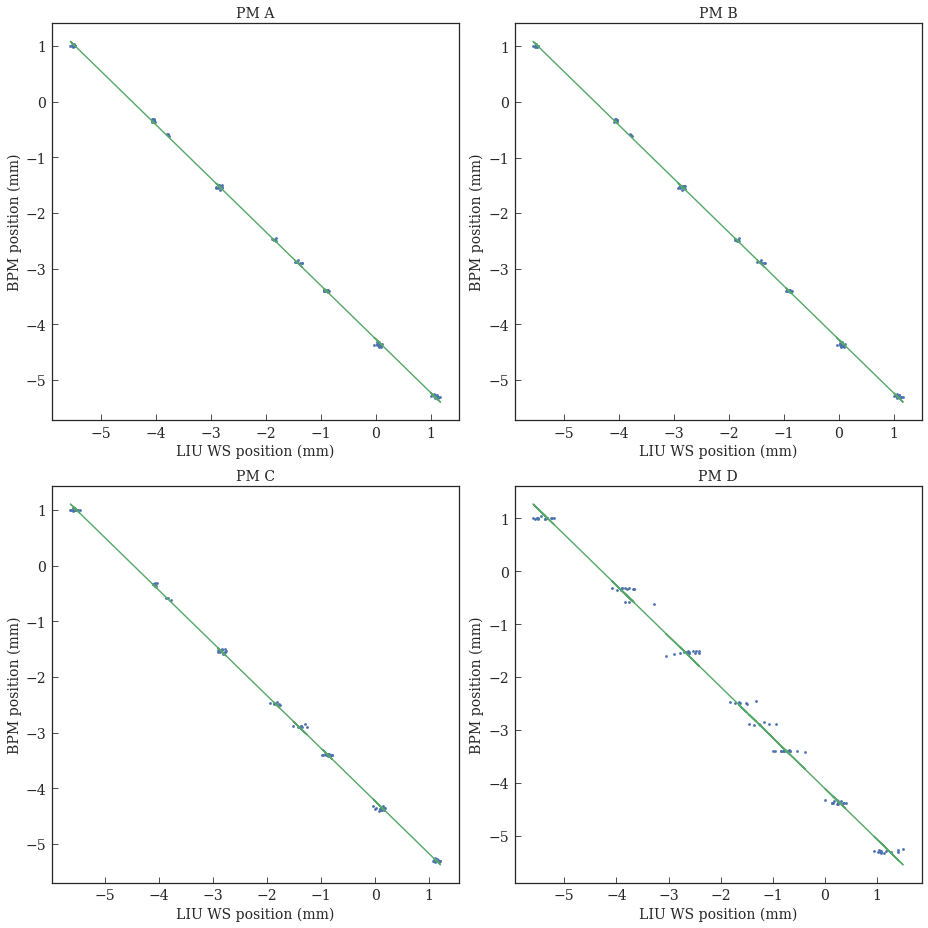

In [82]:
fig, ax = plt.subplots(2,2,figsize=(13,13))

x0 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,3))
yy = myDataFrame['Bump_amplitude']

def print_subplot(ax_obj, row, col, xdata, ydata, title):
    # plotting 
    ax_obj[row,col].set_title(title)
    ax_obj[row,col].plot(xdata, ydata,'.')
    ax_obj[row,col].set_xlabel('LIU WS position (mm)')
    ax_obj[row,col].set_ylabel('BPM position (mm)')
    # fitting 
    popt, pcov = curve_fit(lin, xdata, ydata )
    sig_popt = np.sqrt(np.diag(pcov))
    print(title)
    message = 'slope = %.3f ± %.3f\nintercept = %.3f ± %.3f\n'%(popt[1], sig_popt[1], popt[0], sig_popt[0])
    print(message)
    ax_obj[row,col].plot(xdata, lin(xdata, *popt),'-')

    
print_subplot(ax, 0, 0, x0, yy, 'PM A' )
print_subplot(ax, 0, 1, x1, yy, 'PM B' )
print_subplot(ax, 1, 0, x2, yy, 'PM C' )
print_subplot(ax, 1, 1, x3, yy, 'PM D' )

fig.tight_layout()

# Additional BPMs in the bump


In [32]:
twiss = metaclass.twiss('../optics/output/bump_DHZ51-57.twiss')

In [50]:
idx_ws54 = 1425
idx53 = 1396
idx54 = 1424
idx55 = 1450

print(str(twiss.NAME[idx_ws54])+ ' at '+str(twiss.S[idx_ws54])+' --> offset = '+str(twiss.X[idx_ws54]))
print(str(twiss.NAME[idx53])+ ' at '+str(twiss.S[idx53])+' --> offset = '+str(twiss.X[idx53]))
print(str(twiss.NAME[idx54])+ ' at '+str(twiss.S[idx54])+' --> offset = '+str(twiss.X[idx54]))
print(str(twiss.NAME[idx55])+ ' at '+str(twiss.S[idx55])+' --> offset = '+str(twiss.X[idx55]))
print('Displacement difference between the BPM54 and the wirescanner 54 is '+str(twiss.X[idx54]-twiss.X[idx_ws54]) + ' m')

corr53 = twiss.X[idx_ws54]/twiss.X[idx53]
corr55 = twiss.X[idx_ws54]/twiss.X[idx55]
print('\nCorrection factors due to the bump shape (model dependent !!) \n'+str(corr53)+' , '+str(corr55))


PR.BWSH54 at 334.2688213 --> offset = -0.001271789893
PR.BPM53 at 327.565636 --> offset = -0.001505992407
PR.BPM54 at 333.6688213 --> offset = -0.001274995169
PR.BPM55 at 339.5720066 --> offset = -0.001517145313
Displacement difference between the BPM54 and the wirescanner 54 is -3.205276e-06 m

Correction factors due to the bump shape (model dependent !!) 
0.844486258422 , 0.838278233537


In [51]:
# other BPMs in the bump reported to the BWS location
myDataFrame['Bump_amplitude53'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[21, 500:900])*corr53)
myDataFrame['Bump_amplitude55'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[23, 500:900])*corr55)


---
PM A
slope = -0.961 ± 0.003
intercept = -4.272 ± 0.009

PM A --> BPM53
slope = -1.085 ± 0.005
intercept = -3.016 ± 0.015

PM A --> BPM55
slope = -1.095 ± 0.004
intercept = -1.861 ± 0.012

---
PM B
slope = -0.961 ± 0.003
intercept = -4.272 ± 0.009

PM B --> BPM53
slope = -1.085 ± 0.005
intercept = -3.016 ± 0.015

PM B --> BPM55
slope = -1.096 ± 0.004
intercept = -1.860 ± 0.012

---
PM C
slope = -0.946 ± 0.003
intercept = -4.230 ± 0.009

PM C --> BPM53
slope = -1.069 ± 0.005
intercept = -2.969 ± 0.015

PM C --> BPM55
slope = -1.079 ± 0.004
intercept = -1.812 ± 0.013

---
PM D
slope = -0.960 ± 0.008
intercept = -4.112 ± 0.022

PM D --> BPM53
slope = -1.085 ± 0.009
intercept = -2.837 ± 0.024

PM D --> BPM55
slope = -1.095 ± 0.009
intercept = -1.679 ± 0.024

---


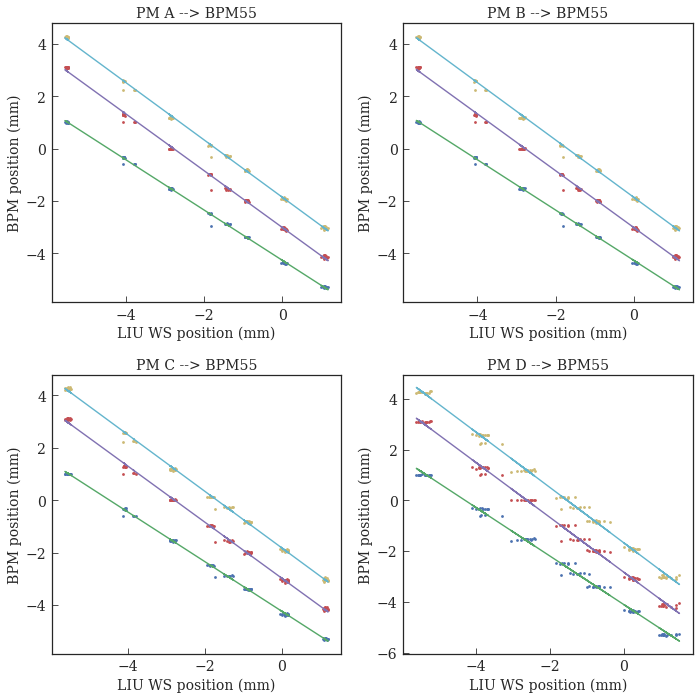

In [55]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

x0 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,3))
yy = myDataFrame['Bump_amplitude']
yy53 = myDataFrame['Bump_amplitude53']
yy55 = myDataFrame['Bump_amplitude55']


print('---')    
print_subplot(ax, 0, 0, x0, yy, 'PM A' )
print_subplot(ax, 0, 0, x0, yy53, 'PM A --> BPM53' )
print_subplot(ax, 0, 0, x0, yy55, 'PM A --> BPM55' )
print('---')
print_subplot(ax, 0, 1, x1, yy, 'PM B' )
print_subplot(ax, 0, 1, x1, yy53, 'PM B --> BPM53' )
print_subplot(ax, 0, 1, x1, yy55, 'PM B --> BPM55' )
print('---')
print_subplot(ax, 1, 0, x2, yy, 'PM C' )
print_subplot(ax, 1, 0, x2, yy53, 'PM C --> BPM53' )
print_subplot(ax, 1, 0, x2, yy55, 'PM C --> BPM55' )
print('---')
print_subplot(ax, 1, 1, x3, yy, 'PM D' )
print_subplot(ax, 1, 1, x3, yy53, 'PM D --> BPM53' )
print_subplot(ax, 1, 1, x3, yy55, 'PM D --> BPM55' )
print('---')

fig.tight_layout()

In [ ]:
- check bump non closure from the BPM data